# Capítulo 7 - DQN


Você pode rodar este notebook no Colab ou localmente. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap07/cap07-main.ipynb) 

## 1 - Configurações Iniciais

### Configurações para Colab


In [1]:
import sys
from IPython.display import clear_output

if 'google.colab' in sys.modules:
    !pip install gym==0.25.1 #0.23.1
    !pip install gym[box2d]
    !pip install opencv-python
    !pip install gym[atari,accept-rom-license]
    !pip install tensorboard

    # para salvar videos
    !apt-get install -y ffmpeg xvfb x11-utils
    #!apt-get install ffmpeg
    !pip install pyvirtualdisplay==0.2.*

    from pyvirtualdisplay import Display
    #global display
    display = Display(visible=False, size=(1400, 900))
    _ = display.start()

    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [2]:
# Set up fake display; otherwise rendering will fail
#import os
#os.system("Xvfb :1 -screen 0 0124x768x24 &")
#os.environ['DISPLAY'] = ':1'

### Configuração do Tensorboard

In [2]:
%load_ext tensorboard

### Configurações para Exibição de Video

In [16]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [4]:
# ideias adaptadas de : https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google
'''from base64 import b64encode
from IPython.display import HTML
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  html_code = f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
  return HTML(html_code)
'''

### Imports

In [13]:
import time
from datetime import datetime
import collections

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter
#from torch.utils.tensorboard import SummaryWriter
#import tensorboard

import matplotlib.pyplot as plt

import dqn_models
from atari_wrappers import *


## 2 - DQN - Definições Auxiliares

Código adaptado do código explicado no livro de M. Lapan, cap. 6.

### Classes Auxiliares

In [11]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class DQNExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, s1, a, r, done, s2):
        experience = Experience(s1, a, r, done, s2)
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

### Funções Auxiliares

In [12]:
# Faz uma escolha epsilon-greedy
def choose_action(qnet, env, state, epsilon, device):
    done_reward = None
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a, dtype=torch.float32).to(device)
        q_vals_v = qnet(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
    return action

In [6]:
# loss function, para treinamento da rede no DQN
def calc_loss(batch, net, tgt_net, gamma, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.tensor(dones, dtype=torch.bool).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = rewards_v + gamma * next_state_values
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [7]:
# Função para testar a política, rodando alguns episódios. Pode, também, renderizar ou gravar um vídeo.
def test_Qpolicy(env, Qpolicy, epsilon=0.0, num_episodes=5, render=False, videorec=None):
    episodes_returns = []
    total_steps = 0
    num_actions = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for i in range(num_episodes):
        obs = env.reset()
        if render:
            env.render()
        if videorec is not None:
            videorec.capture_frame()
        done = False
        steps = 0
        episodes_returns.append(0.0)
        while not done:
            action = choose_action(Qpolicy, env, obs, epsilon, device)
            obs, reward, done, _ = env.step(action)
            if render:
                env.render()
            if videorec is not None:
                videorec.capture_frame()
            total_steps += 1
            episodes_returns[-1] += reward
            steps += 1
        print(f"EPISODE {i+1}")
        print("- steps:", steps)
        print("- return:", episodes_returns[-1])
    mean_return = round(np.mean(episodes_returns), 1)
    print("RESULTADO FINAL: média (por episódio):", mean_return, end="")
    print(", episódios:", len(episodes_returns), end="")
    print(", total de passos:", total_steps)
    if videorec is not None:
        videorec.close()
    return mean_return, episodes_returns


## 3 - DQN - Função Principal

Esta é a função que faz o aprendizado. (Porém, o DQN é uma solução maior, pensada para jogos de Atari, e que inclui também os wrappers.)

In [14]:
def DQN_TRAIN(env, env_name, gamma, qnet, qnet_lr, tgt_qnet, target_update_freq, replay_size, batch_size, epsilon_f, epsilon_decay_period, GOAL_REWARD):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    qnet.to(device)
    tgt_qnet.to(device)

    writer = SummaryWriter(comment="-" + env_name)
    print(qnet)

    buffer = DQNExperienceBuffer(replay_size)
    epsilon = 1.0

    optimizer = optim.Adam(qnet.parameters(), lr=qnet_lr)
    all_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_mean_reward = None
    start_time_str = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")

    state = env.reset()
    total_reward = 0.0

    while True:
        frame_idx += 1
        epsilon = max(epsilon_f, 1.0 - frame_idx / epsilon_decay_period)

        action = choose_action(qnet, env, state, epsilon, device)

        # do step in the environment
        new_state, reward, is_done, _ = env.step(action)
        total_reward += reward

        buffer.append(state, action, reward, is_done, new_state)
        state = new_state
        
        if is_done:
            all_rewards.append(total_reward)
            state = env.reset()
            total_reward = 0.0
            
            # Abaixo, faz vários loggings de dados
            if (time.time() - ts) == 0:
                speed = float("-inf")
            else:
                speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            mean_reward = np.mean(all_rewards[-100:])
            print("%d: done %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
                frame_idx, len(all_rewards), mean_reward, epsilon, speed
            ))
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", total_reward, frame_idx)
            
            # Testa se foi o melhor modelo do treinamento até aqui
            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(qnet.state_dict(), env_name + "-" + start_time_str + "-best.dat")
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            
            # Testa se "resolveu" o ambiente
            if mean_reward > GOAL_REWARD:
                print("Solved in %d steps!" % frame_idx)
                break

        if len(buffer) < replay_size:
            continue

        if frame_idx % target_update_freq == 0:
            tgt_qnet.load_state_dict(qnet.state_dict())
          
        if frame_idx % 50000 == 0:
            clear_output()

        optimizer.zero_grad()
        batch = buffer.sample(batch_size)
        loss_t = calc_loss(batch, qnet, tgt_qnet, gamma, device=device)
        loss_t.backward()
        optimizer.step()

    writer.close()


## 4 - Rodando em Ambientes Simples

In [15]:
ENV_NAME = "MountainCar-v0"
GOAL_REWARD = -120
#ENV_NAME = "CartPole-v0"
#GOAL_REWARD = 200

GAMMA = 0.999
REPLAY_SIZE = 2000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SYNC_TARGET_FRAMES = 250

EPSILON_DECAY_PERIOD = 80000
EPSILON_FINAL = 0.02

env1 = gym.make(ENV_NAME)

qnet = dqn_models.MLP(env1.observation_space.shape[0], [128,256], env1.action_space.n)
qtarget = dqn_models.MLP(env1.observation_space.shape[0], [128,256], env1.action_space.n)

DQN_TRAIN(
    env = env1, 
    env_name = ENV_NAME, 
    gamma = GAMMA, 
    qnet = qnet,
    qnet_lr = LEARNING_RATE,
    tgt_qnet = qtarget, 
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE, 
    batch_size = BATCH_SIZE, 
    epsilon_f = EPSILON_FINAL, 
    epsilon_decay_period = EPSILON_DECAY_PERIOD, 
    GOAL_REWARD = GOAL_REWARD)

50197: done 251 games, mean reward -199.970, eps 0.37, speed 284.89 f/s
50385: done 252 games, mean reward -199.850, eps 0.37, speed 300.12 f/s
Best mean reward updated -199.970 -> -199.850, model saved
50568: done 253 games, mean reward -199.680, eps 0.37, speed 259.92 f/s
Best mean reward updated -199.850 -> -199.680, model saved
50768: done 254 games, mean reward -199.680, eps 0.37, speed 294.49 f/s
50968: done 255 games, mean reward -199.680, eps 0.36, speed 294.90 f/s
51168: done 256 games, mean reward -199.680, eps 0.36, speed 250.67 f/s
51368: done 257 games, mean reward -199.680, eps 0.36, speed 291.90 f/s
51568: done 258 games, mean reward -199.680, eps 0.36, speed 253.20 f/s
51768: done 259 games, mean reward -199.680, eps 0.35, speed 294.04 f/s
51968: done 260 games, mean reward -199.680, eps 0.35, speed 294.04 f/s
52168: done 261 games, mean reward -199.680, eps 0.35, speed 297.09 f/s
52368: done 262 games, mean reward -199.680, eps 0.35, speed 275.08 f/s
52568: done 263 ga

In [ ]:
# Para carregar uma rede salva de arquivo
#qnet.load_state_dict(torch.load("/content/MountainCar-v0-XXXXXX-best.dat", map_location=lambda storage, loc: storage))


In [29]:
# Faz alguns testes com o modelo e salva o vídeo em arquivo

#video = VideoRecorder(env1, "./dqn-test/")  # <--- acho que este funciona melhor!
#test_Qpolicy(env1, qnet, 0.0, 10, render=False, videorec=video);


video_env=gym.wrappers.RecordVideo(gym.make(ENV_NAME), "./dqn-test", episode_trigger=(lambda ep : True))
test_Qpolicy(video_env, qnet, 0.0, 5, render=False, videorec=None)
video_env.close()

d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07\dqn-test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


EPISODE 1
- steps: 107
- return: -107.0
EPISODE 2
- steps: 117
- return: -117.0
EPISODE 3
- steps: 108
- return: -108.0
EPISODE 4
- steps: 108
- return: -108.0
EPISODE 5
- steps: 111
- return: -111.0
RESULTADO FINAL: média (por episódio): -110.2, episódios: 5, total de passos: 551


In [ ]:
#render_mp4("politica-mc.mp4")

In [ ]:
from util.notebook import display_videos_from_path

display_videos_from_path('./dqn-test')

## 5 - Visualização dos Resultados

Estamos, aqui, usando o **Tensorboard**, criado para o Tensorflow, mas compatível com Pytorch. Ele pode também ser iniciado antes, e ser usado para acompanhar o treinamento.

In [ ]:
%tensorboard --logdir runs
#clear_output()

In [ ]:
# Para mostrar o Tensorboard com menos espaço
#tensorboard.notebook.display(height=500) 

## 6 - Rodando no Jogo Pong (Atari)

In [ ]:
ENV_NAME = "PongNoFrameskip-v4"
GOAL_REWARD = 0.0  # tente com 19.5  (esta é a diferença de pontos para o player "cpu")

#ENV_NAME = "Breakout??"

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 20000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000

EPSILON_DECAY_PERIOD = 10**5
EPSILON_FINAL = 0.02

env2 = gym.make(ENV_NAME)
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

dqn_net = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)
tgt_dqn_net = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


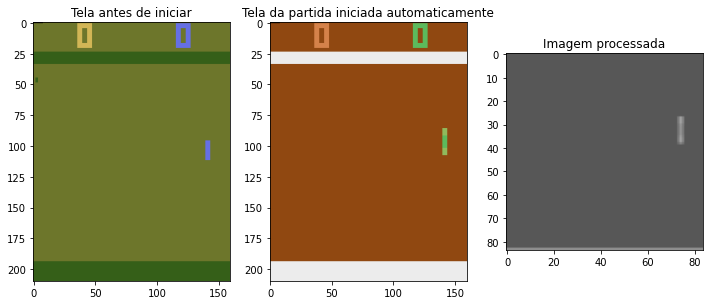

In [13]:
# Mostrando tela do ambiente original, e após passar por alguns wrappers
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

s = env2.reset()
ax1.imshow(s)
ax1.set_title('Tela antes de iniciar')

s = env2b.reset()
ax2.imshow(s)
ax2.set_title('Tela da partida iniciada automaticamente')

s = env2d.reset()
ax3.imshow(s[0], cmap='gray', vmin=0, vmax=255)  # exibe em escala de cinza
ax3.set_title('Imagem processada');

In [ ]:
DQN_TRAIN(
    env = env2f, 
    env_name = ENV_NAME, 
    gamma = GAMMA, 
    qnet = dqn_net,
    qnet_lr = LEARNING_RATE,
    tgt_qnet = tgt_dqn_net, 
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE, 
    batch_size = BATCH_SIZE, 
    epsilon_f = EPSILON_FINAL, 
    epsilon_decay_period = EPSILON_DECAY_PERIOD, 
    GOAL_REWARD = GOAL_REWARD)

In [14]:
# Para carregar uma rede salva de arquivo
# Permite continuar um treinamento, ou permite carregar para salvar o vídeo
#filename = "/content/PongNoFrameskip-v4-agente-treinado.net"
#dqn_net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
#if torch.cuda.is_available():
#  dqn_net.to("cuda")
#EPSILON_DECAY_PERIOD = 1

In [ ]:
# Faz alguns testes com o modelo e salva o vídeo em arquivo
video = VideoRecorder(env2f, "politica-pong.mp4")
test_Qpolicy(env2f, dqn_net, 0.0, 3, render=False, videorec=video);

In [17]:
render_mp4("politica-pong.mp4")